In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [29]:
DATA_PATH = 'C:\Code\olymp_bot\data\olympia.csv'

In [30]:
data = pd.read_csv(DATA_PATH, usecols=['pool_count', 'date'], index_col=['date'], parse_dates=['date'])

In [4]:
from datetime import datetime, timedelta

def make_future_dataset(data):
    start = data.index.max()
    end = datetime(start.year, start.month, start.day, 22, 30)
    
    dates = pd.date_range(start=start, end=end, freq='min')
    dates = dates[dates > start]
    
    dates = pd.DataFrame(dates)
    dates.columns = ['date']
    
    return dates

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

def code_std(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].std())

In [32]:
data_future = make_future_dataset(data)
data_future.set_index('date', inplace=True)

In [33]:
lag_start = len(data_future)
lag_end = lag_start + 600
idx = len(data)

In [34]:
len(data), len(data_future)

(5917, 262)

In [35]:
data.tail()

,pool_count
date,
2018-10-25 18:03:45.447317,99
2018-10-25 18:04:46.323995,97
2018-10-25 18:05:47.181906,97
2018-10-25 18:06:48.032911,97
2018-10-25 18:07:49.276637,96


In [31]:
data = data[data['pool_count'] > 0]

In [48]:
rolling_mean = data.rolling(window=60*24).mean()

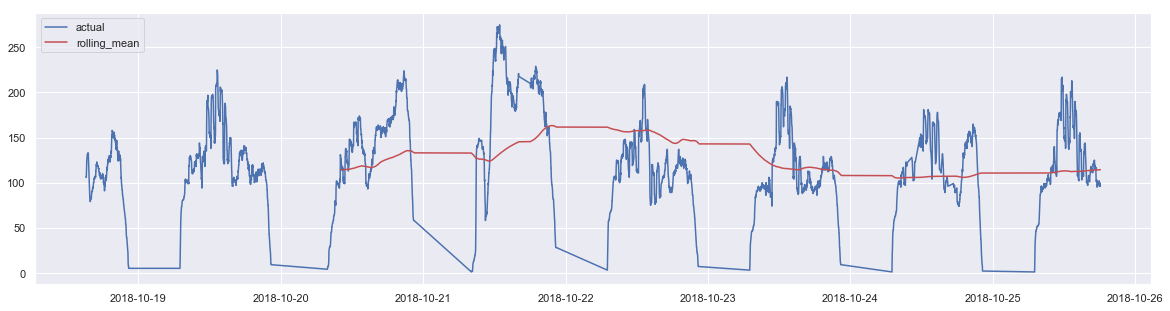

In [49]:
plt.figure(figsize=(20, 5))
plt.plot(data, color='b', label="actual")
plt.plot(rolling_mean, color='r', label="rolling_mean")
#plt.axvspan(data.index.max(), data_future.index.max(), facecolor='r', alpha=0.25)
plt.legend(loc='upper left')
plt.grid(True)
plt.show();

In [38]:
temp = pd.concat([data, data_future])

In [39]:
temp['hour'] = temp.index.hour
temp['minute'] = temp.index.minute

In [40]:
temp['hour_average'] = list(map(code_mean(temp[:idx], 'hour', "pool_count").get, temp.hour))
temp["min_average"] = list(map(code_mean(temp[:idx], 'minute', "pool_count").get, temp.minute))

temp['hour_std'] = list(map(code_std(temp[:idx], 'hour', "pool_count").get, temp.hour))
temp["min_std"] = list(map(code_std(temp[:idx], 'minute', "pool_count").get, temp.minute))

# выкидываем закодированные средними признаки 
temp.drop(["hour", "minute"], axis=1, inplace=True)

In [41]:
for i in range(lag_start, lag_end + 1):
    temp["lag_{}".format(i)] = temp.pool_count.shift(i)

In [42]:
temp.head()

,pool_count,hour_average,min_average,hour_std,min_std,lag_262,lag_263,lag_264,lag_265,lag_266,...,lag_853,lag_854,lag_855,lag_856,lag_857,lag_858,lag_859,lag_860,lag_861,lag_862
date,,,,,,,,,,,,,,,,,,,,,
2018-10-18 15:09:34.982631,106.0,126.329787,121.294118,33.786826,49.976745,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 15:14:35.956450,106.0,126.329787,120.102041,33.786826,50.795423,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 15:19:36.797380,125.0,126.329787,122.796117,33.786826,51.687477,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 15:24:37.758122,131.0,126.329787,121.441176,33.786826,51.161281,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 15:29:38.660701,133.0,126.329787,123.140000,33.786826,48.818778,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#temp.fillna(0, inplace=True)
#temp.dropna(inplace=True)
for col in temp.columns:
    if col.startswith('lag_'):
        temp[col].fillna(temp[col].mean(), inplace=True)

In [44]:
X_train = temp.iloc[:idx].drop(['pool_count'], axis=1)
y_train = temp.iloc[:idx]['pool_count']
X_test = temp.iloc[idx:].drop(['pool_count'], axis=1)
y_test = temp.iloc[idx:]['pool_count']

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
#plt.figure(figsize=(15, 7))
#plt.plot(prediction, "r", label="prediction")
#plt.plot(data, label="actual")
#plt.legend(loc="best")
#plt.title("Linear regression\n Mean absolute error {} visitors".format(round(mean_absolute_error(prediction, y_test))))
#plt.grid(True);

In [21]:
from sklearn.linear_model import LassoCV, RidgeCV

In [36]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [25]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
prediction = lr.predict(X_test)

In [46]:
pred_future = pd.DataFrame(prediction)
pred_future.columns = ['pool_count']
pred_future.index = data_future.index

In [207]:
#len(data_future), len(pred_future)

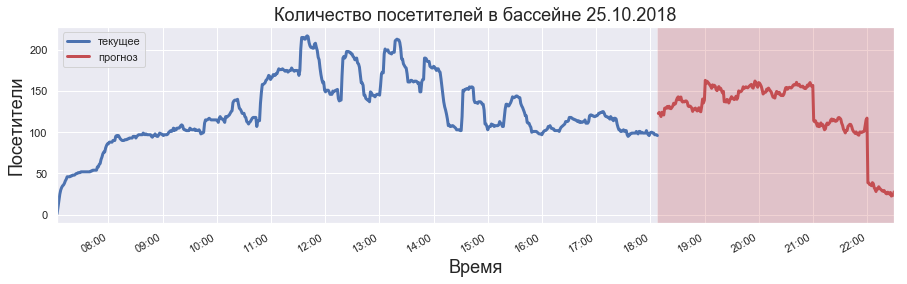

In [47]:
hours = mdates.HourLocator()  
hourFmt = mdates.DateFormatter('%H:%M')

# Load a numpy record array from yahoo csv data with fields date, open, close,
# volume, adj_close from the mpl-data/example directory. The record array
# stores the date as an np.datetime64 with a day unit ('D') in the date column.
#with cbook.get_sample_data('goog.npz') as datafile:
#    r = np.load(datafile)['price_data'].view(np.recarray)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(data['2018-10-24 07:00:00':], 'b', label='текущее', linewidth=3.0)
ax.plot(pred_future, 'r', label='прогноз', linewidth=3.0)

ax.legend(loc='upper left')
ax.axvspan(data.index.max(), data_future.index.max(), facecolor='r', alpha=0.25)
ax.set_ylabel('Посетители', fontsize=18)
ax.set_xlabel('Время', fontsize=18)
ax.set_title('Количество посетителей в бассейне {}'.format(datetime.now().strftime("%d.%m.%Y")), fontsize=18)

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hourFmt)
#ax.xaxis.set_minor_locator(hours)

# round to nearest years...
datemin = data['2018-10-25 07:00:00':].index.min()
datemax = data_future.index.max()
ax.set_xlim(datemin, datemax)

#ax.format_xdata = mdates.DateFormatter('%H')

#ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()